# Atividade 8 - Classificador MLP

# PCA

# Algoritmo MLPClassifier

● Seguir o mesmo padrão das atividades 6 e 7, mas agora para redes MLP

● Realizar validação cruzada para testar redes neurais (mesmos subconjuntos utilizados em SVMs)
utilizando:

    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)
    
Em cada um, calibrar os parâmetros (número de neurônios da camada oculta (ex: 10, raiz quadrada
do nr de características, um nr maior), taxa de aprendizado (ex: 0,1; 0,01), função de ativação
(sigmoide na camada de saída, mas na camada oculta testar tangente hiperbólica e leaky relu (ou
relu)) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou
melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing

# PCA
from sklearn.decomposition import PCA

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.neural_network import MLPClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


## Pré-Processamento

In [3]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [4]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [5]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [6]:
df_imp = df_processed.copy()

In [7]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## PCA (matriz de correlação)

In [8]:
scaler = preprocessing.StandardScaler()
X_imp = df_imp.drop('Biopsy', axis=1)

X_std = pd.DataFrame(scaler.fit_transform(X_imp) , columns = X_imp.columns.tolist())

#X_std.describe()

In [9]:
pca_corr = PCA()
pca_corr.fit(X_std)

#pd.DataFrame(pca_corr.get_covariance(), columns = df_imp.columns.tolist()).head()

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
autovalores_corr = pca_corr.explained_variance_.tolist()
variancia_corr = pca_corr.explained_variance_ratio_
variancia_acumulada_corr = np.cumsum(variancia_corr.tolist())

print('\tAuto-valores\tVariância explicada\tVariância acumulada')
print()

for (num,item) in enumerate(variancia_acumulada_corr):
    print(num+1,'\t' + '%0.3f' % autovalores_corr[num] + '\t\t' +'%0.3f' %variancia_corr[num],'\t\t\t'+ '%0.2f' %item)

	Auto-valores	Variância explicada	Variância acumulada

1 	5.116		0.155 			0.15
2 	3.028		0.092 			0.25
3 	2.473		0.075 			0.32
4 	2.078		0.063 			0.38
5 	2.017		0.061 			0.45
6 	1.716		0.052 			0.50
7 	1.546		0.047 			0.54
8 	1.361		0.041 			0.59
9 	1.278		0.039 			0.62
10 	1.235		0.037 			0.66
11 	1.064		0.032 			0.69
12 	1.029		0.031 			0.72
13 	1.008		0.031 			0.76
14 	0.935		0.028 			0.78
15 	0.857		0.026 			0.81
16 	0.843		0.026 			0.83
17 	0.811		0.025 			0.86
18 	0.795		0.024 			0.88
19 	0.745		0.023 			0.91
20 	0.654		0.020 			0.93
21 	0.572		0.017 			0.94
22 	0.478		0.014 			0.96
23 	0.320		0.010 			0.97
24 	0.276		0.008 			0.98
25 	0.234		0.007 			0.98
26 	0.175		0.005 			0.99
27 	0.125		0.004 			0.99
28 	0.092		0.003 			0.99
29 	0.076		0.002 			1.00
30 	0.066		0.002 			1.00
31 	0.030		0.001 			1.00
32 	0.008		0.000 			1.00
33 	0.000		0.000 			1.00
34 	0.000		0.000 			1.00
35 	0.000		0.000 			1.00


In [11]:
max_var = []
for num in range(0, len(variancia_corr)):
    if variancia_corr[num] > 0.02: # threshold - queremos variancia mais que 0.02
        max_var.append(num)

best_var = max(max_var)
# +1 porque a tabela acima começa com 1 e nao com 0 
print('{} - {:.3f}'.format(best_var+1,variancia_corr[best_var]))

19 - 0.023


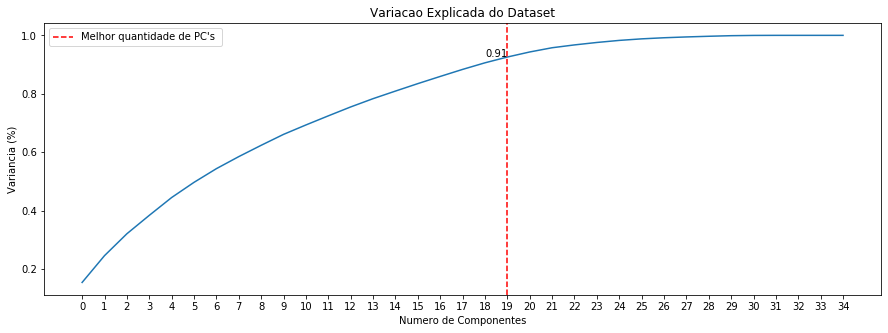

In [12]:
# Plotando o somatório cumulativo da variação explicada
PCA_MinMax = plt.figure(figsize=(15,5))
plt.plot(np.cumsum(variancia_corr))
plt.xlabel('Numero de Componentes')
plt.ylabel('Variancia (%)') #for each component
plt.xticks(range(0,35))
plt.axvline(best_var+1, 0, 1, label='Melhor quantidade de PC\'s ',  color='r', linestyle='--')
plt.legend()
plt.title('Variacao Explicada do Dataset')
plt.annotate('{:.2f}'.format(variancia_acumulada_corr[best_var]),
            xy=(best_var, variancia_acumulada_corr[best_var]+0.02), )
plt.show()

PCA_MinMax.savefig("PCA_MinMax.png", bbox_inches='tight', dpi=600)

In [13]:
numero_pcs = 12

pca_corr = PCA(n_components=numero_pcs)
df_pca = pd.DataFrame(pca_corr.fit_transform(X_std))
df_pca = df_pca.join(df_imp['Biopsy'])

df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,Biopsy
0,-0.812794,-1.027713,-0.345730,0.404814,1.065889,-0.094993,-1.244200,-0.121671,-0.511764,-0.161274,-0.640401,-0.024927,0
1,-0.899581,-1.273092,-0.714819,0.461576,1.137768,0.103364,-1.278365,0.102784,-0.571242,-0.076486,0.094807,-0.310428,0
2,-0.815938,-0.654859,-0.485203,0.345225,0.145280,-0.174008,-0.648445,0.855768,0.219859,0.964201,-0.281150,-0.091465,0
3,1.486542,11.659519,10.984382,-3.329641,6.830262,-4.235778,0.054968,2.353689,-0.520529,0.664479,1.122866,0.796374,0
4,-0.630968,0.984599,0.638390,-0.135557,-2.382956,-0.246635,3.192497,0.173844,1.119634,0.324930,-0.080460,-0.044784,0


## Stratified Cross- Validation

### Dataset Desbalanceado

In [14]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    n_Neurons_range = grid_params.get('n_Neurons_range')
    learning_rate_init_range = grid_params.get('learning_rate_init_range')
    learning_rate_init_step = grid_params.get('learning_rate_init_step')
    f_Activation = grid_params.get('f_Activation')
    
    # Testa varias funções de ativação
    for func in f_Activation:
        print("-> Teste função {}".format(func))
        
        # Testa varios numeros de neuronios
        for neuronios in list(np.arange(n_Neurons_range[0], n_Neurons_range[1], 1)):
#             print("\t\tTeste Param neuronios {}".format(neuronios))
        
            # Testa varios learning_rate
            for learning_rate_i in list(np.arange(learning_rate_init_range[0], learning_rate_init_range[1], learning_rate_init_step)):
#                print("\t\t\tTeste Param learning_rate {}".format(learning_rate_i))

                print('-> Criando modelo com params neuronios={}, learning_rate={}'.format(neuronios, learning_rate_i))
                clf = algoritmo(activation=func, hidden_layer_sizes=(neuronios,), learning_rate_init=learning_rate_i, verbose=0)

                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))

                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([neuronios, learning_rate_i, func, fold_number, precision, recall, accuracy])



    return np.array(scores)

### Dataset Balanceado

In [15]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    n_Neurons_range = grid_params.get('n_Neurons_range')
    learning_rate_init_range = grid_params.get('learning_rate_init_range')
    learning_rate_init_step = grid_params.get('learning_rate_init_step')
    f_Activation = grid_params.get('f_Activation')
    
    # Testa varias funções de ativação
    for func in f_Activation:
        print("-> Teste função {}".format(func))
        
        # Testa varios numeros de neuronios
        for neuronios in list(np.arange(n_Neurons_range[0], n_Neurons_range[1], 1)):
#             print("\t\tTeste Param neuronios {}".format(neuronios))
        
            # Testa varios learning_rate
            for learning_rate_i in list(np.arange(learning_rate_init_range[0], learning_rate_init_range[1], learning_rate_init_step)):
#                     print("\t\t\tTeste Param learning_rate {}".format(learning_rate_i))

                print('-> Criando modelo com params neuronios={}, learning_rate={}'.format(neuronios, learning_rate_i))
                clf = algoritmo(activation=func, hidden_layer_sizes=(neuronios,), learning_rate_init=learning_rate_i, verbose=0)

                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # Normaliza MinMax para aplicar Smote
                    X_train_normalized = minmax_scale.fit_transform(X_train)
                    X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                    # SMOTETomek (apenas os dados de treino)
                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                    X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                    # Retorna para valores não normalizados
                    X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                    print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                             y_train.value_counts()[0], 
                                                                                             y_train.value_counts()[1], 
                                                                                             ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                             ((y_train.value_counts()[1]/len(y_train))*100)))

                    # quantidade de classes dentro da fold
                    count_classes_fold = y_test.value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('\t\tDados de teste (desbalanceados)')
                    print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([neuronios, learning_rate_i, func, fold_number, precision, recall, accuracy])

            
    return np.array(scores)

## Grid de Parametros para teste

In [16]:
grid_params_all = {'n_Neurons_range': [6,10],
               'learning_rate_init_range': [0.001, 0.01],
                'learning_rate_init_step': 0.001,
               'f_Activation': ['logistic', 'tanh', 'relu']
              }

## Calculando Precisão, Revocação e Acurácia

### Algortimo-> MLPClassifier

### Dataset Desbalanceado

In [17]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_pca, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'n_Neurons', 1: 'learning_rate_init', 2: 'f_Activation', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'MLPClassifier'
float_cols = ['n_Neurons', 'learning_rate_init', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste função logistic
-> Criando modelo com params neuronios=6, learning_rate=0.001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6

In [18]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-PCA_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,n_Neurons,learning_rate_init,f_Activation,Fold,Precision,Recall,Accuracy,Algorimto
0,6,0.001,logistic,1,0.0,0.0,0.941860,MLPClassifier
1,6,0.001,logistic,2,0.0,0.0,0.941860,MLPClassifier
2,6,0.001,logistic,3,0.0,0.0,0.941860,MLPClassifier
3,6,0.001,logistic,4,0.0,0.0,0.930233,MLPClassifier
4,6,0.001,logistic,5,0.0,0.0,0.930233,MLPClassifier


### Dataset Balanceado

In [19]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_pca, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=True))
scores_balanced = scores_balanced.rename(columns = {0: 'n_Neurons', 1: 'learning_rate_init', 2: 'f_Activation', 3:'Fold', 
                                                    4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'MLPClassifier'
float_cols = ['n_Neurons', 'learning_rate_init', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste função logistic
-> Criando modelo com params neuronios=6, learning_rate=0.001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 722 positivas e 722 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 722 positivas e 722 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados 

In [20]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-PCA_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

,n_Neurons,learning_rate_init,f_Activation,Fold,Precision,Recall,Accuracy,Algorimto
0,6,0.001,logistic,1,0.500000,1.000000,0.941860,MLPClassifier
1,6,0.001,logistic,2,0.714286,1.000000,0.976744,MLPClassifier
2,6,0.001,logistic,3,0.333333,0.800000,0.895349,MLPClassifier
3,6,0.001,logistic,4,0.857143,1.000000,0.988372,MLPClassifier
4,6,0.001,logistic,5,0.400000,0.666667,0.906977,MLPClassifier


## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [21]:
mean_unbalanced = scores_unbalanced.groupby(['n_Neurons', 'learning_rate_init', 'f_Activation']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
n_Neurons learning_rate_init f_Activation                               
6         0.001              logistic       0.000000  0.000000  0.935910
                             relu           0.707381  0.673333  0.959207
                             tanh           0.633571  0.693333  0.946334
          0.002              logistic       0.100000  0.020000  0.937086
                             relu           0.637897  0.676667  0.951067
                             tanh           0.675000  0.693333  0.954501
          0.003              logistic       0.235000  0.193333  0.940561
                             relu           0.693571  0.676667  0.956881
                             tanh           0.688333  0.656667  0.956840
          0.004              logistic       0.516190  0.453333  0.953352
                             relu           0.755000  0.586667  0.959220
                             tanh           0.728333  0.633333  0.960369
          0.005              logistic       0.699524  0.580000  0.960369
                             relu           0.738333  0.583333  0.958071
                             tanh           0.689921  0.653333  0.956867
          0.006              logistic       0.756190  0.636667  0.961546
                             relu           0.651190  0.593333  0.952202
                             tanh           0.642778  0.620000  0.951026
          0.007              logistic       0.740000  0.620000  0.960383
                             relu           0.627143  0.540000  0.948741
                             tanh           0.637976  0.656667  0.952161
          0.008              logistic       0.605833  0.556667  0.952161
                             relu           0.722857  0.660000  0.959207
                             tanh           0.670833  0.673333  0.955677
          0.009              logistic       0.630952  0.583333  0.955691
                             relu           0.663810  0.640000  0.954528
                             tanh           0.655952  0.600000  0.948687
7         0.001              logistic       0.000000  0.000000  0.935910
                             relu           0.718415  0.660000  0.937168
                             tanh           0.678968  0.713333  0.956854
          0.002              logistic       0.309524  0.126667  0.938235
                             relu           0.697857  0.623333  0.958044
                             tanh           0.700000  0.623333  0.955705
          0.003              logistic       0.590000  0.526667  0.956840
                             relu           0.709167  0.626667  0.956895
                             tanh           0.684524  0.636667  0.955705
          0.004              logistic       0.519524  0.416667  0.953365
                             relu           0.690000  0.583333  0.955677
                             tanh           0.677976  0.620000  0.954542
          0.005              logistic       0.714524  0.556667  0.960369
                             relu           0.663690  0.623333  0.951040
                             tanh           0.701667  0.636667  0.958044
          0.006              logistic       0.692500  0.636667  0.956854
                             relu           0.744524  0.633333  0.960383
                             tanh           0.666905  0.626667  0.952216
          0.007              logistic       0.724524  0.616667  0.958030
                             relu           0.659524  0.586667  0.951040
                             tanh           0.640873  0.653333  0.950999
          0.008              logistic       0.687857  0.636667  0.956854
                             relu           0.683333  0.643333  0.954555
                             tanh           0.672857  0.656667  0.955663
          0.009              logistic       0.712857  0.656667  0.960369
                             relu           0.644524  0.590000  0.948741
                            

In [22]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision    Recall  Accuracy
n_Neurons learning_rate_init f_Activation                               
9         0.002              relu           0.760357  0.680000  0.962722
8         0.002              relu           0.756190  0.623333  0.961546
6         0.006              logistic       0.756190  0.636667  0.961546
          0.007              logistic       0.740000  0.620000  0.960383
7         0.006              relu           0.744524  0.633333  0.960383

(9, 0.002, 'relu')

### Dataset Balanceado

In [23]:
mean_balanced = scores_balanced.groupby(['n_Neurons', 'learning_rate_init', 'f_Activation']).mean().drop('Fold', axis = 1)
mean_balanced

Precision    Recall  Accuracy
n_Neurons learning_rate_init f_Activation                               
6         0.001              logistic       0.501825  0.890000  0.925349
                             relu           0.534949  0.816667  0.935896
                             tanh           0.500893  0.850000  0.928851
          0.002              logistic       0.539652  0.850000  0.933543
                             relu           0.523203  0.796667  0.934720
                             tanh           0.517633  0.850000  0.928878
          0.003              logistic       0.566017  0.850000  0.937045
                             relu           0.540295  0.816667  0.933598
                             tanh           0.510685  0.833333  0.930068
          0.004              logistic       0.562608  0.830000  0.937059
                             relu           0.576959  0.836667  0.940575
                             tanh           0.536492  0.816667  0.937059
          0.005              logistic       0.569805  0.850000  0.938208
                             relu           0.557551  0.836667  0.941710
                             tanh           0.546230  0.800000  0.938194
          0.006              logistic       0.573214  0.793333  0.942886
                             relu           0.552827  0.800000  0.938249
                             tanh           0.570040  0.763333  0.940561
          0.007              logistic       0.568240  0.800000  0.940534
                             relu           0.506187  0.743333  0.932421
                             tanh           0.581245  0.796667  0.942873
          0.008              logistic       0.609794  0.813333  0.946389
                             relu           0.546667  0.776667  0.935910
                             tanh           0.599643  0.800000  0.946361
          0.009              logistic       0.595040  0.776667  0.944049
                             relu           0.582183  0.723333  0.946361
                             tanh           0.593268  0.820000  0.941724
7         0.001              logistic       0.492045  0.850000  0.923010
                             relu           0.546457  0.833333  0.932435
                             tanh           0.497370  0.870000  0.926484
          0.002              logistic       0.539955  0.850000  0.933529
                             relu           0.598626  0.803333  0.942900
                             tanh           0.510385  0.870000  0.933516
          0.003              logistic       0.549221  0.870000  0.937031
                             relu           0.543864  0.833333  0.937059
                             tanh           0.562713  0.820000  0.942845
          0.004              logistic       0.577890  0.850000  0.941710
                             relu           0.594643  0.730000  0.941724
                             tanh           0.554960  0.800000  0.940520
          0.005              logistic       0.589199  0.833333  0.945198
                             relu           0.556800  0.796667  0.942859
                             tanh           0.563476  0.833333  0.939398
          0.006              logistic       0.601190  0.830000  0.942900
                             relu           0.520054  0.780000  0.933557
                             tanh           0.520894  0.813333  0.934706
          0.007              logistic       0.614315  0.796667  0.946361
                             relu           0.617868  0.780000  0.948687
                             tanh           0.551667  0.730000  0.940561
          0.008              logistic       0.599636  0.816667  0.945226
                             relu           0.586165  0.800000  0.942900
                             tanh           0.523303  0.780000  0.934733
          0.009              logistic       0.574722  0.796667  0.942886
                             relu           0.608373  0.780000  0.949836
                            

In [24]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision    Recall  Accuracy
n_Neurons learning_rate_init f_Activation                               
9         0.005              relu           0.641587  0.756667  0.951067
          0.007              logistic       0.633431  0.833333  0.951040
8         0.006              logistic       0.608431  0.853333  0.949863
7         0.009              relu           0.608373  0.780000  0.949836
8         0.003              relu           0.619221  0.780000  0.948728

(9, 0.005, 'relu')

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [25]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['n_Neurons'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['learning_rate_init'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['f_Activation'] == max_alpha_unbalanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.963, IC = [0.949, 0.977]
Recall: Média = 0.680, IC = [0.545, 0.815]
Precisão: Média = 0.760, IC = [0.624, 0.897]


### Dataset Balanceado

In [26]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['n_Neurons'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['learning_rate_init'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['f_Activation'] == max_alpha_balanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.951, IC = [0.930, 0.973]
Recall: Média = 0.757, IC = [0.627, 0.887]
Precisão: Média = 0.642, IC = [0.479, 0.804]


## Gráfico

In [27]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

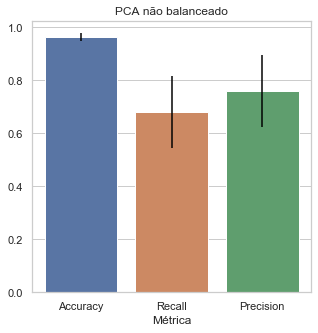

In [28]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('PCA não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('PCA nao balanceado - MLPClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

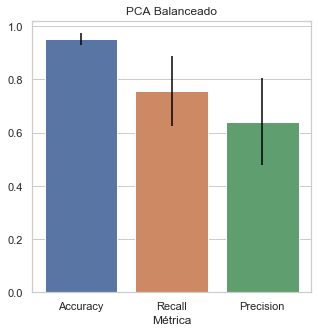

In [29]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('PCA Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('PCA balanceado - MLPClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [30]:
path_to_save = '../../model_results/'
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    '8',
    'MLPClassifier',
    'PCA Desbalanceado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    '8',
    'MLPClassifier',
    'PCA Balanceado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Atividade,Algoritmo,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,7,SVC,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Accuracy,0.960383,NaN
1,7,SVC,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Recall,0.86,NaN
2,7,SVC,Dataset Completo Desbalanceado - Nao Normalizado,"('linear', 1, 'scale')",Precision,0.677579,NaN
3,7,SVC,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.962709,NaN
4,7,SVC,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Recall,0.876667,NaN
5,7,SVC,Dataset Completo Balanceado - Nao Normalizado,"('rbf', 100, '0.0001')",Precision,0.690079,NaN
6,7,SVC,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.962709,NaN
7,7,SVC,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Recall,0.876667,NaN
8,7,SVC,Dataset Completo Desbalanceado - Normalizado,"('rbf', 100, '0.0001')",Precision,0.690079,NaN
9,7,SVC,Dataset Completo Balanceado - Normalizado,"('rbf', 100, '0.0001')",Accuracy,0.959193,NaN


Resultados salvos com sucesso
